# Система автоматического распознавания цифровых изображений мусора

- [train/val/test split](#train/val/test-split)
- [Datset](#Dataset)
- [GPU connection](#GPU-connection)
- [Model](#Model)
- [Training](#Training)
- [Testing](#Testing)

## train/val/test split

In [20]:
import os
import shutil

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers

DATASET_PATH = os.path.join(os.getcwd(), 'dataset')
TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
VAL_PATH = os.path.join(DATASET_PATH, 'val')
TEST_PATH = os.path.join(DATASET_PATH, 'test')
# модель
NUM_CLASSES = len(os.listdir(os.path.join(DATASET_PATH, 'entire dataset')))
IMAGE_SIZE = (300, 300)
INPUT_SHAPE = (*IMAGE_SIZE, 3)
BATCH_SIZE = 16
POOL_SIZE = (2, 2)
# обучение
NUM_EPOCHS = 700
MODEL_PATH = os.path.join(os.getcwd(), 'model.hdf5')

In [2]:
def rename_files(path):
    """Переименовывает файлы в подкаталогах таким образом, чтобы файлы назывались как подкаталог.
    
    Например, в подкаталоге есть папка с названием 'cat.png'. Тогда функция переименует все файлы
    в ней на 'cat_i.png', где i - это номер картинки в каталоге.
    """
    dirnames = os.listdir(path)
    for dirname in dirnames:
        dirpath = os.path.join(path, dirname)
        file_names = os.listdir(dirpath)
        for i, file_name in enumerate(file_names):
            extension = file_name.split('.')[-1]
            old_path = os.path.join(dirpath, file_name)
            new_path = os.path.join(dirpath, f'{dirname}_{i}.{extension}')
            try:
                os.rename(old_path, new_path)
            except:
                pass


rename_files(os.path.join(DATASET_PATH, 'entire dataset'))

In [3]:
def clean_dir(path):
    """Очищает содержимое директории по пути."""
    for content_name in os.listdir(path):
        content_path = os.path.join(path, content_name)
        if os.path.isdir(content_path):
            # чистит директорию
            clean_dir(content_path)
            # удаляет пустую директорию
            os.rmdir(content_path)
        elif os.path.isfile(content_path):
            os.remove(content_path)


def check_create_path(path):
    """Проверяет, существует ли дирректория, соответствующая заданному пути. Если нет, создаёт его."""
    if not os.path.exists(path):
        os.mkdir(path)


def send(dst_path, file_paths):
    clean_dir(dst_path)
    for file_path in file_paths:
        shutil.copy2(file_path, dst_path)


def train_val_test_split(dataset_path, *, val_split=0.1, test_split=0.1):
    """Разбивает целый датасет на обучающую, валидационную и тестовую части.
    
    Args:
        dataset_path: путь до целого датасета,
        val_split: коэффициент валидационной части,
        test_split: коэффициент тестовой части.
    """
    entire_dataset_path = os.path.join(dataset_path, 'entire dataset')
    labels = os.listdir(entire_dataset_path)
    rng = np.random.default_rng()  # рандом генератор
    
    part_names = ['train', 'val', 'test']
    part_paths = [os.path.join(dataset_path, part_name) for part_name in part_names]
    for part_path in part_paths:
        check_create_path(part_path)
        clean_dir(part_path)
    
    for label in labels:
        # путь до директории с картинками, принадлежащими одному классу
        label_path = os.path.join(entire_dataset_path, label)
        # создаём список из имён файлов в этой директории
        file_names = os.listdir(label_path)
        # создаём список из путей до файлов
        file_paths = [os.path.join(label_path, file_name) for file_name in file_names]
        # перемешиваем список из путей
        rng.shuffle(file_names)
        
        size = len(file_names)
        val_size = int(size * val_split)
        test_size = int(size * test_split)
        
        val_index = val_size
        test_index = val_size + test_size
        
        val_part = file_paths[:val_index]
        test_part = file_paths[val_index:test_index]
        train_part = file_paths[test_index:]
        
        parts = [train_part, val_part, test_part]
        part_label_paths = [os.path.join(part_path, label) for part_path in part_paths]
        
        for part_label_path, part in zip(part_label_paths, parts):
            check_create_path(part_label_path)
            send(part_label_path, part)


train_val_test_split(DATASET_PATH)

## Dataset

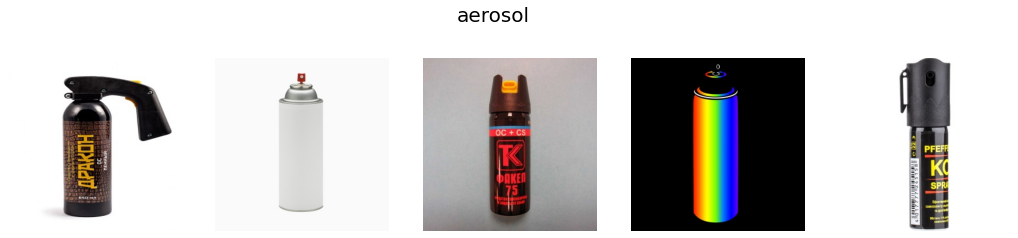

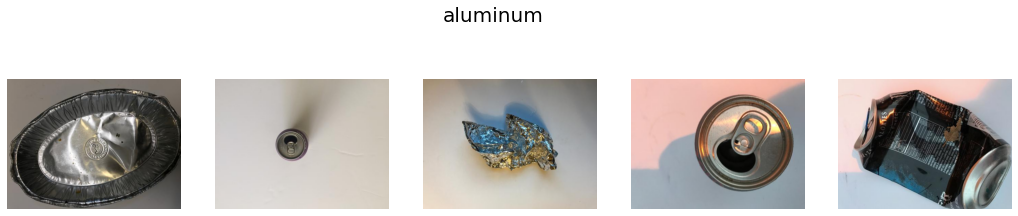

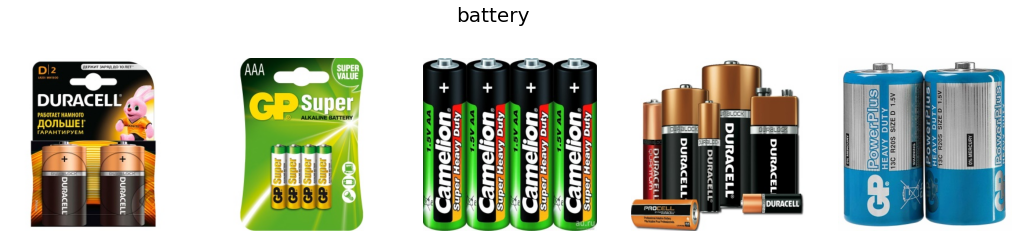

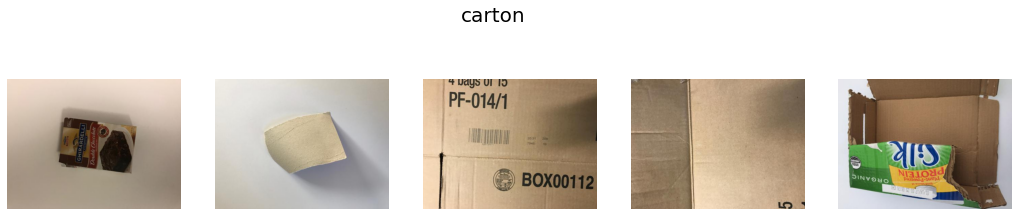

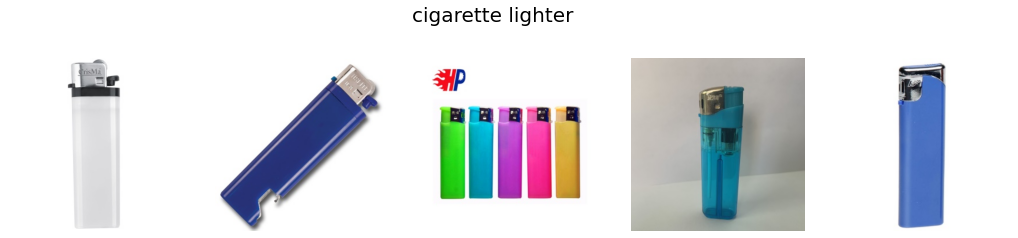

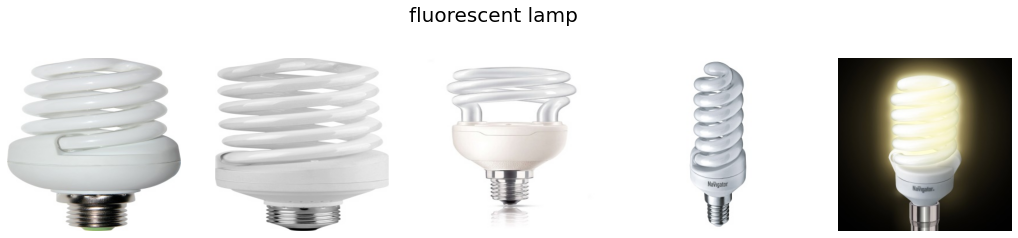

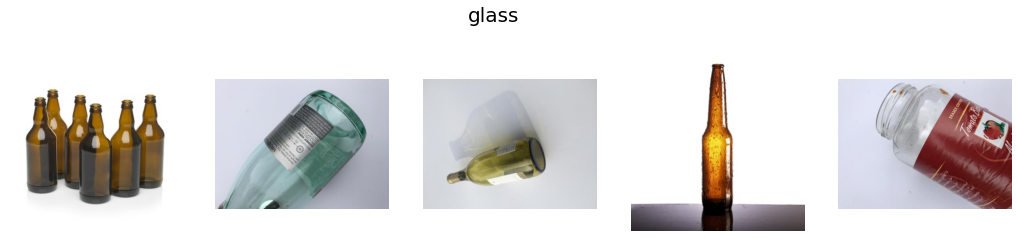

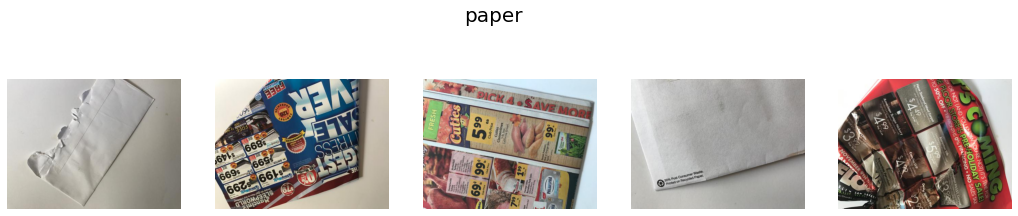

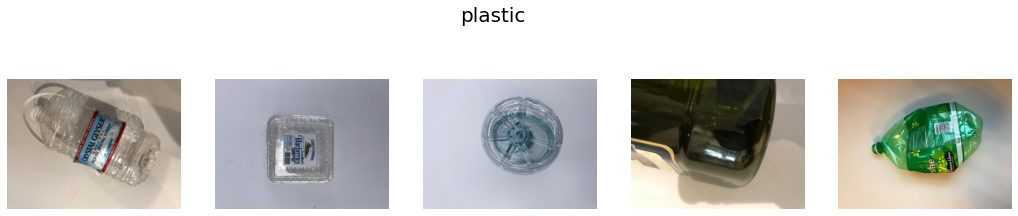

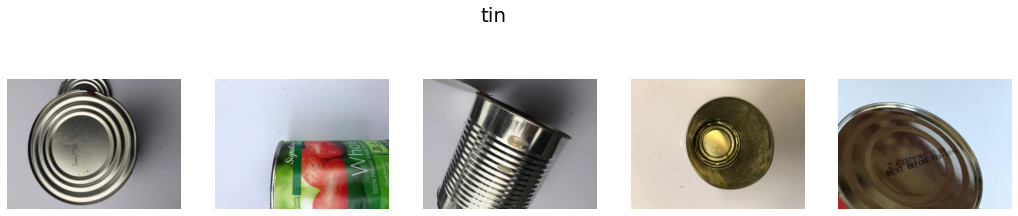

In [4]:
def show_images(path, shape, figsize, *, suptitle=None):
    """Показывает изображения.
    
    Args:
        path: путь к директории, из которой показывать изображения.
        shape: форма сколько на рисунке показывать изображений.
        figsize: размер рисунка.
        suptitle: заголовок.
    """
    n_rows, n_columns = shape

    file_names = os.listdir(path)

    rng = np.random.default_rng()
    random_file_names = rng.choice(file_names, size=(n_rows * n_columns), replace=False)

    fig, axes = plt.subplots(*shape, figsize=figsize)
    axes = axes.flatten()
    for ax, random_file_name in zip(axes, random_file_names):
        random_image = plt.imread(os.path.join(path, random_file_name))
        ax.imshow(random_image)
        ax.set_axis_off()
    fig.suptitle(suptitle, fontsize=20)
    plt.show(fig)


entire_dataset_path = os.path.join(DATASET_PATH, 'entire dataset')
label_names = os.listdir(entire_dataset_path)
sizes = []
for label_name in label_names:
    label_path = os.path.join(entire_dataset_path, label_name)
    
    size = len(os.listdir(label_path))
    sizes.append(size)
    
    show_images(label_path, (1, 5), (18, 4), suptitle=label_name)

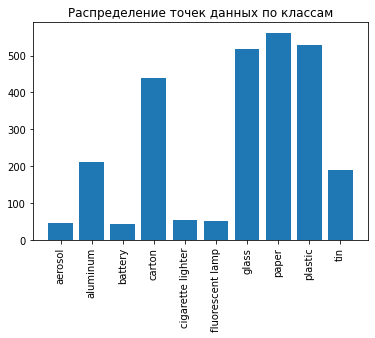

In [5]:
ax = plt.subplot()
ax.bar(label_names, sizes)
ax.set_xticks(label_names)
ax.set_xticklabels(label_names, rotation=90)
ax.set_title('Распределение точек данных по классам')
plt.show()

## GPU connection

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    # Restrict TensorFlow to only use the first GPU
    try:
        # Currently, memory growth needs to be the same across GPUs
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        
        tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f'{len(physical_devices)} Physical GPUs, {len(logical_gpus)} Logical GPU')
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


## Model

In [7]:
model = tf.keras.models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', input_shape=INPUT_SHAPE, activation='relu'),
        layers.MaxPooling2D(pool_size=POOL_SIZE),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=POOL_SIZE),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=POOL_SIZE),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

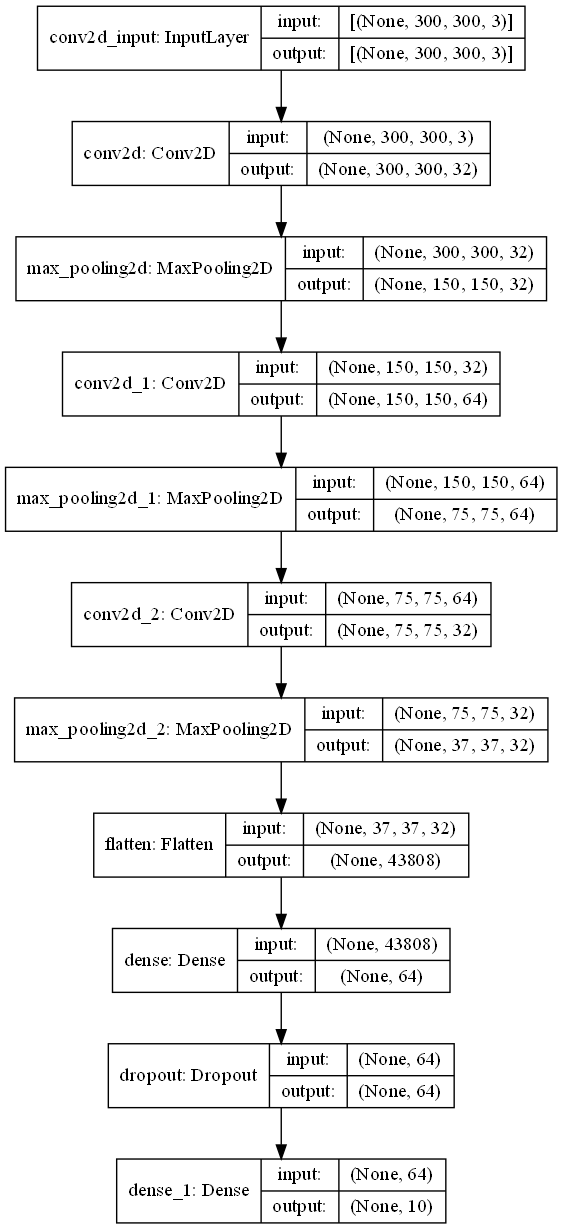

In [8]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, rankdir='TB', dpi=100)

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255, rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
train_datagen = train_generator.flow_from_directory(
    TRAIN_PATH, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

val_test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
val_datagen = val_test_generator.flow_from_directory(
    VAL_PATH, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_datagen = val_test_generator.flow_from_directory(
    TEST_PATH, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

Found 2122 images belonging to 10 classes.
Found 259 images belonging to 10 classes.
Found 259 images belonging to 10 classes.


In [11]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH, monitor='val_accuracy', save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_datagen, epochs=NUM_EPOCHS, verbose=0, callbacks=callbacks_list, validation_data=val_datagen)

In [12]:
model.evaluate(test_datagen)

17/17 [==============================] - 2s 124ms/step - loss: 0.5943 - accuracy: 0.8649


[0.5942731499671936, 0.8648648858070374]

In [13]:
h5_model = tf.keras.models.load_model(MODEL_PATH)
h5_model.evaluate(test_datagen)

17/17 [==============================] - 2s 50ms/step - loss: 0.5565 - accuracy: 0.8842


[0.5565434694290161, 0.88416987657547]

In [14]:
def plot_history(history, mode):
    """Визуализирует историю обучения.
    
    Args:
        history: собственно история.
        mode: {'accuracy', 'loss'} что отображать точность или потери.
    """
    ax = plt.subplot()
    ax.plot(history.history[f'{mode}'])
    ax.plot(history.history[f'val_{mode}'])
    ax.set_xlabel('epochs')
    ax.set_ylabel(f'{mode}')
    ax.legend(['train', 'val'])

    plt.show()

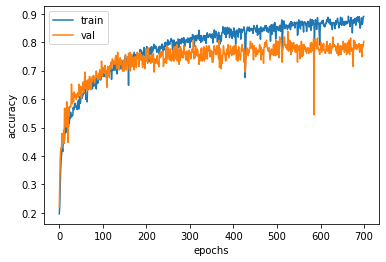

In [15]:
plot_history(history, 'accuracy')

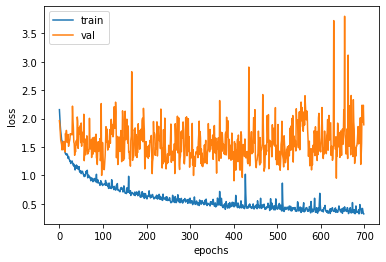

In [16]:
plot_history(history, 'loss')

## Testing

In [17]:
def load_image(path):
    """Загружает изображение в пригодном для tensoflow формате.
    
    Args:
        path: путь, по которому лежит изображение.

    Returns:
        image: изображение в прогодном для tensorflow формате.
    """
    raw = tf.io.read_file(path)
    image = tf.io.decode_jpeg(raw, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image[tf.newaxis]
    image = tf.image.resize(image, IMAGE_SIZE)
    return image


def predict_label(model, image, labels):
    """Предсказывает метку для изображения."""
    predict = model.predict(image)
    predicted_label = labels[predict[0].argmax()]
    return predicted_label


def get_true_predict_labels(model, path):
    """Возвращает настоящие и предсказанные метки для картинок в директории."""
    true_labels = []
    predict_labels = []
    labels = os.listdir(path)
    
    for dir_name in labels:
        dir_path = os.path.join(path, dir_name)
        file_paths = [os.path.join(dir_path, file_name) for file_name in os.listdir(dir_path)]
        for file_path in file_paths:
            true_labels.append(dir_name)
            
            image = load_image(file_path)
            predicted_label = predict_label(model, image, labels)
            predict_labels.append(predicted_label)
    
    return true_labels, predict_labels

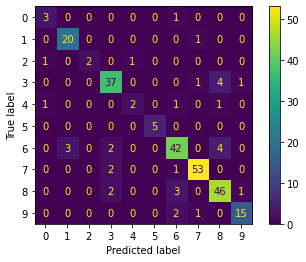

In [22]:
true_labels, predict_labels = get_true_predict_labels(model, TEST_PATH)
cm = confusion_matrix(true_labels, predict_labels)
ConfusionMatrixDisplay(cm).plot()